In [ ]:
APENAS UM JUPYTER DE TESTE 

In [1]:
# === Spark robusto (usa o mesmo Python do kernel e Java 17) ===
import os, sys, subprocess
from pyspark.sql import SparkSession

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
try:
    os.environ["JAVA_HOME"] = subprocess.check_output(
        ["/usr/libexec/java_home","-v","17"]
    ).decode().strip()
except Exception:
    pass

prev = SparkSession.getActiveSession()
if prev is not None:
    prev.stop()

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("Bronze-Analytics-PySpark")
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow")
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
print("Spark =>", spark.version)

# Caminho BRONZE (ajuste se necessário)
RAW_DIR = "/Users/kalebmacedo/formula1-analytics-1/bronze/dados_originais"

# Matplotlib para desenhar (sem pandas)
import matplotlib.pyplot as plt


25/09/24 15:32:36 WARN Utils: Your hostname, MacBook-Air-de-Kaleb.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
25/09/24 15:32:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/24 15:32:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark => 3.5.1


Matplotlib is building the font cache; this may take a moment.


In [ ]:
.

In [2]:
from pyspark.sql import functions as F, Window

seasons = spark.read.csv(f"{RAW_DIR}/seasons.csv", header=True, inferSchema=True)
constructors = spark.read.csv(f"{RAW_DIR}/constructors.csv", header=True, inferSchema=True)

print("Seasons — amostra")
seasons.show(5, truncate=False)
seasons.printSchema()

print("\nConstructors — amostra")
constructors.show(5, truncate=False)
constructors.printSchema()


Seasons — amostra
+----+----------------------------------------------------+
|year|url                                                 |
+----+----------------------------------------------------+
|2009|http://en.wikipedia.org/wiki/2009_Formula_One_season|
|2008|http://en.wikipedia.org/wiki/2008_Formula_One_season|
|2007|http://en.wikipedia.org/wiki/2007_Formula_One_season|
|2006|http://en.wikipedia.org/wiki/2006_Formula_One_season|
|2005|http://en.wikipedia.org/wiki/2005_Formula_One_season|
+----+----------------------------------------------------+
only showing top 5 rows

root
 |-- year: integer (nullable = true)
 |-- url: string (nullable = true)


Constructors — amostra
+-------------+--------------+----------+-----------+------------------------------------------------------------+
|constructorId|constructorRef|name      |nationality|url                                                         |
+-------------+--------------+----------+-----------+--------------------------------

In [3]:
def qualidade(df, pk_cols=None, nome="df"):
    total = df.count()
    miss = [(c, df.filter(F.col(c).isNull() | (F.col(c)=="\\N")).count()) for c in df.columns]
    miss = [(c, m, round(100*m/total,2)) for c,m in miss]
    print(f"== {nome} ==")
    print("Total:", total)
    spark.createDataFrame(miss, ["coluna","missing","pct"]).orderBy(F.desc("pct")).show(truncate=False)
    dup_rows = df.groupBy(df.columns).count().filter("count>1").count()
    print("Duplicatas (linhas idênticas):", dup_rows)
    if pk_cols:
        dup_pk = df.groupBy(*pk_cols).count().filter("count>1").count()
        print(f"Duplicatas de PK {pk_cols}:", dup_pk)

qualidade(seasons, pk_cols=["year"], nome="Seasons")
qualidade(constructors, pk_cols=["constructorId"], nome="Constructors")


== Seasons ==
Total: 75
+------+-------+---+
|coluna|missing|pct|
+------+-------+---+
|year  |0      |0.0|
|url   |0      |0.0|
+------+-------+---+

Duplicatas (linhas idênticas): 0
Duplicatas de PK ['year']: 0
== Constructors ==
Total: 212
+--------------+-------+---+
|coluna        |missing|pct|
+--------------+-------+---+
|constructorId |0      |0.0|
|name          |0      |0.0|
|nationality   |0      |0.0|
|constructorRef|0      |0.0|
|url           |0      |0.0|
+--------------+-------+---+

Duplicatas (linhas idênticas): 0
Duplicatas de PK ['constructorId']: 0


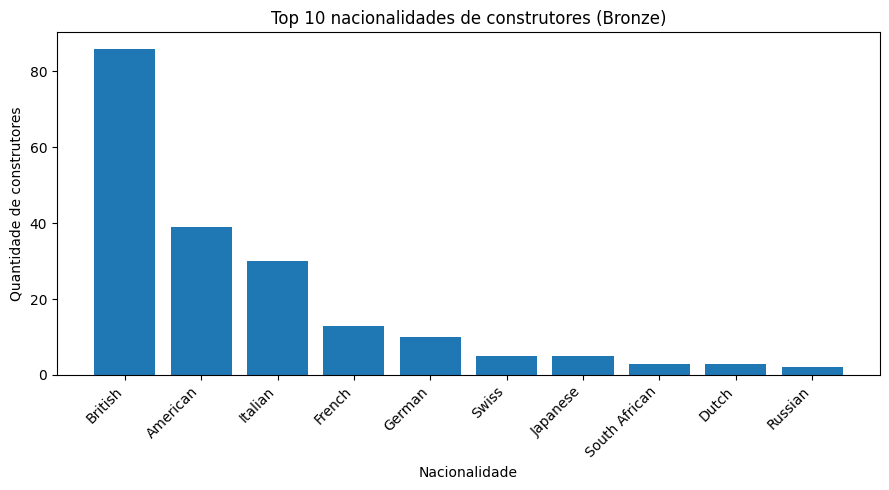

In [4]:
# Aggregation em PySpark
top_nat = (constructors
           .groupBy("nationality")
           .count()
           .orderBy(F.desc("count"))
           .limit(10))

# Converte para listas Python
rows = top_nat.collect()
labels = [r["nationality"] if r["nationality"] is not None else "N/A" for r in rows]
values = [int(r["count"]) for r in rows]

plt.figure(figsize=(9,5))
plt.bar(labels, values)
plt.title("Top 10 nacionalidades de construtores (Bronze)")
plt.xlabel("Nacionalidade")
plt.ylabel("Quantidade de construtores")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


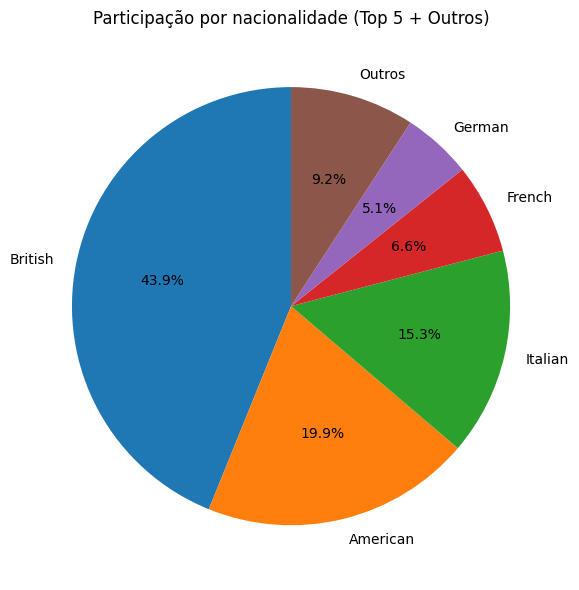

In [5]:
top5 = top_nat.orderBy(F.desc("count")).limit(5)
soma_top5 = top5.agg(F.sum("count").alias("s")).first()["s"]
soma_total = top_nat.agg(F.sum("count").alias("s")).first()["s"]
outros_val = int(soma_total - soma_top5)

rows5 = top5.collect()
labels = [r["nationality"] if r["nationality"] is not None else "N/A" for r in rows5]
sizes  = [int(r["count"]) for r in rows5]
if outros_val > 0:
    labels.append("Outros")
    sizes.append(outros_val)

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Participação por nacionalidade (Top 5 + Outros)")
plt.tight_layout()
plt.show()


Equação: year ≈ 1.000000 * X + 1950.000000


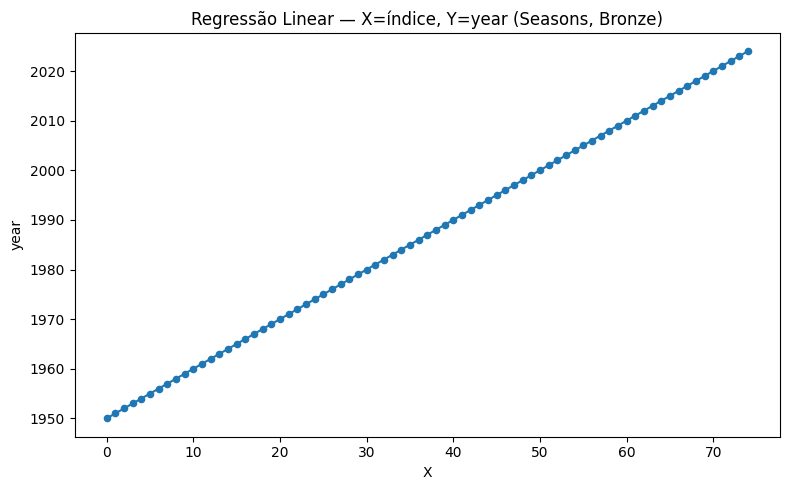

In [7]:
from pyspark.sql import functions as F, Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# X = índice (0..N-1) ordenado por year
w = Window.orderBy("year")
xy = (seasons
      .select(
          F.row_number().over(w).alias("idx"),
          F.col("year").cast("double").alias("year")
      )
      .withColumn("X", F.col("idx") - 1)
      .select("X", "year")
      .dropna())

# features = [X] sem UDF
assembler = VectorAssembler(inputCols=["X"], outputCol="features")
xy_ml = assembler.transform(xy).select(F.col("year").alias("label"), "features")

# Regressão linear (reta)
lr = LinearRegression(featuresCol="features", labelCol="label")
model = lr.fit(xy_ml)
a = float(model.coefficients[0]); b = float(model.intercept)
print(f"Equação: year ≈ {a:.6f} * X + {b:.6f}")

# Predições para plotar
pred = model.transform(xy_ml).select("features", F.col("label").alias("year"), F.col("prediction").alias("y_pred"))
extract_x = F.udf(lambda v: float(v[0]), "double")
pred2 = pred.withColumn("X", extract_x(F.col("features"))).select("X","year","y_pred").orderBy("X")

rows = pred2.collect()
xs = [r["X"] for r in rows]
ys = [r["year"] for r in rows]
yhat = [r["y_pred"] for r in rows]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.scatter(xs, ys, s=20)
plt.plot(xs, yhat)
plt.title("Regressão Linear — X=índice, Y=year (Seasons, Bronze)")
plt.xlabel("X"); plt.ylabel("year")
plt.tight_layout(); plt.show()
